<a href="https://colab.research.google.com/github/eyet7/Markowitz-portfolio-optimization/blob/main/notebooks/01_markowitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Core libraries for data handling, visualization, and financial data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("seaborn-v0_8")

## Data Description

We use daily adjusted closing prices for five large-cap U.S. assets : AAPL, MSFT, GOOGL, AMZN, and SPY.

The sample period spans 2019-2024.

Adjusted prices are used to account for dividends and stock splits, ensuring consistency in return computation.

In [2]:
# Assests selection
tickers = ["AAPL", "MSFT","GOOGL", "AMZN", "SPY"]

#Download historical adjusted prices
prices = yf.download(
    tickers,
    start='2019-01-01',
    end='2024-01-01',
    auto_adjust=True
)
prices.head()
prices.shape

[*********************100%***********************]  5 of 5 completed


(1258, 25)

In [3]:
# Keep only adjusted close prices.
prices_close = prices["Close"]
prices_close.head()

Ticker,AAPL,AMZN,GOOGL,MSFT,SPY
Date,,,,,
2019-01-02,37.503727,76.956497,52.338547,94.612617,224.995331
2019-01-03,33.768085,75.014000,50.889000,91.131989,219.626312
2019-01-04,35.209610,78.769501,53.499275,95.370468,226.982849
2019-01-07,35.131248,81.475502,53.392582,95.492096,228.772522
2019-01-08,35.800961,82.829002,53.861542,96.184494,230.921936


In [4]:
# Compute daily returns
returns = prices_close.pct_change().dropna()
returns.head()

Ticker,AAPL,AMZN,GOOGL,MSFT,SPY
Date,,,,,
2019-01-03,-0.099607,-0.025241,-0.027696,-0.036788,-0.023863
2019-01-04,0.042689,0.050064,0.051294,0.046509,0.033496
2019-01-07,-0.002226,0.034353,-0.001994,0.001275,0.007885
2019-01-08,0.019063,0.016612,0.008783,0.007251,0.009395
2019-01-09,0.016982,0.001714,-0.003428,0.014300,0.004673


## Return Computation

Daily simple returns are computed as:
r_t = (P_t / P_{t-1}) - 1

The first observation is removed due to the lag structure.

All subsequent analysis is based on these daily returns. And Simple returns are used instead of log-returns for consistency with the standard mean–variance framework.



In [5]:
# Annualized expected returns
mu = returns.mean(axis=0) * 252

# Annalized covariance matrix
cov = returns.cov() * 252

mu, cov

(Ticker
 AAPL     0.378031
 AMZN     0.198360
 GOOGL    0.245988
 MSFT     0.320295
 SPY      0.167224
 dtype: float64,
 Ticker      AAPL      AMZN     GOOGL      MSFT       SPY
 Ticker                                                  
 AAPL    0.103907  0.070302  0.069207  0.074562  0.054450
 AMZN    0.070302  0.124055  0.073902  0.073346  0.047956
 GOOGL   0.069207  0.073902  0.101188  0.073616  0.050897
 MSFT    0.074562  0.073346  0.073616  0.092969  0.052788
 SPY     0.054450  0.047956  0.050897  0.052788  0.044082)

## Parameter Estimation

Expected returns (μ) and covariance matrix (Σ) are annualized assuming 252 trading days per year.

These are historical estimates and represent backward-looking inputs.

Expected returns are typically unstable and highly sensitive to the estimation window. Because mean–variance optimization relies heavily on μ, small estimation errors can lead to large and unstable shifts in optimal portfolio weights, amplifying estimation risk.

In [6]:
# Equal-weight portfolio

n_assets = len (mu)
w_equal = np.ones(n_assets) / n_assets
portfolio_return = np.dot(w_equal, mu)
portfolio_variance = np.dot(w_equal.T, np.dot(cov, w_equal))
portfolio_volatility = np.sqrt(portfolio_variance)

print(f"Expected annual return: {portfolio_return:.2%}")
print(f"Annual volatility: {portfolio_volatility:.2%}")


Expected annual return: 26.20%
Annual volatility: 26.44%


## Equal-Weight Portfolio

The equal-weight portfolio serves as a neutral benchmark
with allocation :

w_i = 1/N

It provides diversification without optimization and allows comparison with optimized portfolios.

In [7]:
sharpe = portfolio_return / portfolio_volatility
print(f"Sharpe ratio (no risk-free rate): {sharpe:.2f}")


Sharpe ratio (no risk-free rate): 0.99


In [8]:
# Reproducibility
np.random.seed(42)

n_portfolios = 5000
n_assests = len (mu)

#Arrays to store results
port_returns = np.zeros(n_portfolios)
port_vols = np.zeros(n_portfolios)
port_sharpes = np.zeros(n_portfolios)
weights_store = np.zeros((n_portfolios, n_assests))

for i in range(n_portfolios):
  # Random long-only weights that sum to 1
  w = np.random.random(n_assets)
  w = w / w.sum()

  weights_store[i, :] = w

  # Portfolio return and risk
  r = np.dot(w, mu)
  v = np.sqrt(np.dot(w.T, np.dot(cov, w)))

  port_returns[i] = r
  port_vols[i] = v
  port_sharpes[i] = r / v


## Random Portfolio Simulation

5,000 random long-only portfolios were generated.

This simulation illustrates the feasible risk-return region under constraint:
- w_i ≥ 0
- ∑ w_i = 1

Most portfolios lie inside the feasible risk–return region. Only the upper envelope represents non-dominated (efficient) allocations. However, random simulation merely samples the weight space and does not solve the underlying constrained optimization problem. As a result, it may fail to identify the exact efficient frontier, motivating the use of deterministic quadratic programming.




In [9]:
# Identify best Sharpe and minimum volatility portfolios
idx_max_sharpe = np.argmax(port_sharpes)
idx_min_vol = np.argmin(port_vols)

best_w = weights_store[idx_max_sharpe]
minvol_w = weights_store[idx_min_vol]

best_point = (port_vols[idx_max_sharpe], port_returns[idx_max_sharpe])
minvol_point = (port_vols[idx_min_vol], port_returns[idx_min_vol])

tickers = list(mu.index)

def pretty_portfolio(name, w, mu, cov):
  w = np.array(w)
  expected_return = float(np.dot(w,mu))
  volatility = float(np.sqrt(np.dot(w.T, np.dot(cov, w))))
  sharpe_ratio = expected_return / volatility

  # Create readable weight table
  weights = pd.Series(w, index=tickers).sort_values(ascending=False)

  print(f"\n{name}")
  print("-"* len(name))
  print(f"Sum of weights:         {w.sum():.6f}")
  print(f"Expected annual return: {expected_return:.2%}")
  print(f"Annual volatility:      {volatility: .2%}")
  print(f"Sharpe ratio (rf=0):    {sharpe_ratio:.2f}\n")

  print("portfolio weights:")
  display(weights.to_frame("Weight"))

# Display the two key portfolios
pretty_portfolio("Maximum Sharpe Portfolio (Random Search)", best_w, mu, cov)
pretty_portfolio("Minimum Volatility Portfolio (Random Search)",minvol_w, mu, cov )

print("\nKey points (vol, return);")
print(f"Max Sharpe point: {best_point}")
print(f"Min Vol point:    {minvol_point}")




Maximum Sharpe Portfolio (Random Search)
----------------------------------------
Sum of weights:         1.000000
Expected annual return: 33.79%
Annual volatility:       28.86%
Sharpe ratio (rf=0):    1.17

portfolio weights:


,Weight
AAPL,0.549354
MSFT,0.305281
GOOGL,0.096331
SPY,0.032881
AMZN,0.016153



Minimum Volatility Portfolio (Random Search)
--------------------------------------------
Sum of weights:         1.000000
Expected annual return: 21.28%
Annual volatility:       22.70%
Sharpe ratio (rf=0):    0.94

portfolio weights:


,Weight
SPY,0.678088
MSFT,0.146385
AAPL,0.079286
GOOGL,0.073051
AMZN,0.023189



Key points (vol, return);
Max Sharpe point: (np.float64(0.28862842306550734), np.float64(0.3378515006142643))
Min Vol point:    (np.float64(0.22698026917940087), np.float64(0.2128213255765976))


The maximum Sharpe portfolio from random search lies near the upper boundary of the cloud, while the minimum volatility portfolio is located on the lower-left boundary.
However, random sampling may fail to reach the true optimal solutions, motivating the use of deterministic optimization.


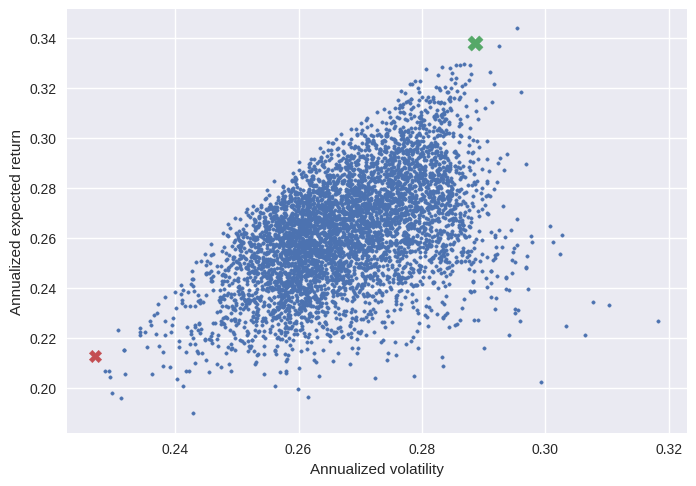

In [10]:
# Plot

plt.figure()
plt.scatter(port_vols, port_returns, s=6)
plt.xlabel("Annualized volatility")
plt.ylabel("Annualized expected return")

# Highlight max Sharpe and min vol portfolios
plt.scatter([best_point[0]], [best_point[1]], s=120, marker="X", label="Max Sharpe (random)")
plt.scatter([minvol_point[0]], [minvol_point[1]], s=80, marker="X", label = "Min vol (random)")

plt.show()

The upper boundary of the cloud visually approximates the efficient frontier. However, random sampling does not guarantee that the true optimal portfolios are identified, especially in high-dimensional weight spaces.


## From Random Search to Exact Optimization

In the previous section, portfolios were generated using a random search approach.
While this provides an intuitive visualization of the risk-return space, it does not guarantee that the true optimal portfolios are identified.

To obtain exact solutions, we now solve the Markowitz optimization problem using numerical optimization.

We compute:
- The Minimum Volatility Portfolio
- The Maximum Sharpe Ratio Portfolio (with a non-zero risk-free rate)

The optimization is performed under the following constraints:
- Fully invested portfolio (weights sum to 1)
- Long-only positions (no short selling)

=> This step moves from simulation-based approximation to a constrained quadratic optimization framework.




In [11]:
from scipy.optimize import minimize
tickers = list(mu.index)
n_assets = len(tickers)

def portfolio_performance(w, mu, cov):
    """Return (expected_return, volatility) with annualized inputs."""
    w = np.array(w)
    r = float(np.dot(w, mu))
    v = float(np.sqrt(np.dot(w.T, np.dot(cov, w))))
    return r, v

def portfolio_volatility(w, mu, cov):
    return portfolio_performance(w, mu, cov)[1]

def negative_sharpe(w, mu, cov, rf=0.02):
    r, v = portfolio_performance(w, mu, cov)
    return -(r - rf) / v

# Constraints: sum(w)=1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds: long-only
bounds = tuple((0.0, 1.0) for _ in range(n_assets))

# Initial guess: equal weights
w0 = np.ones(n_assets) / n_assets


In [12]:
# Minimum volatility portfolio (long-only)
res_minvol = minimize(
    portfolio_volatility, w0,
    args=(mu, cov),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

w_minvol_opt = res_minvol.x

# Maximum Sharpe portfolio (long-only), with risk-free rate
rf = 0.02  # 2% annual risk-free rate (assumption)
res_maxsharpe = minimize(
    negative_sharpe, w0,
    args=(mu, cov, rf),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

w_maxsharpe_opt = res_maxsharpe.x

res_minvol.success, res_maxsharpe.success


(True, True)

In [13]:
def display_portfolio(name, w, mu, cov, rf=0.02):
    w = np.array(w)
    r, v = portfolio_performance(w, mu, cov)
    sharpe = (r - rf) / v

    weights = pd.Series(w, index=tickers).sort_values(ascending=False)

    print(f"\n{name}")
    print("-" * len(name))
    print(f"Sum of weights:         {w.sum():.6f}")
    print(f"Expected annual return: {r:.2%}")
    print(f"Annual volatility:      {v:.2%}")
    print(f"Sharpe ratio (rf={rf:.2%}): {sharpe:.2f}\n")
    print("Portfolio weights:")
    display(weights.to_frame("Weight"))

display_portfolio("Optimized Min Vol Portfolio (SLSQP)", w_minvol_opt, mu, cov, rf=rf)
display_portfolio("Optimized Max Sharpe Portfolio (SLSQP)", w_maxsharpe_opt, mu, cov, rf=rf)



Optimized Min Vol Portfolio (SLSQP)
-----------------------------------
Sum of weights:         1.000000
Expected annual return: 16.72%
Annual volatility:      21.00%
Sharpe ratio (rf=2.00%): 0.70

Portfolio weights:


,Weight
SPY,1.000000e+00
AMZN,6.678685e-17
MSFT,3.469447e-18
AAPL,0.000000e+00
GOOGL,0.000000e+00



Optimized Max Sharpe Portfolio (SLSQP)
--------------------------------------
Sum of weights:         1.000000
Expected annual return: 36.11%
Annual volatility:      30.13%
Sharpe ratio (rf=2.00%): 1.13

Portfolio weights:


,Weight
AAPL,7.064257e-01
MSFT,2.935743e-01
SPY,4.016825e-17
GOOGL,0.000000e+00
AMZN,0.000000e+00


## Optimized Portfolios (SLSQP) - Interpretation

### Minimum Volatility Portfolio
Under long-only and fully-invested constraints, the minimum-variance solution becomes a corner portfolio.
In this universe, SPY has the lowest estimated variance and a covariance structure such that adding other assets does not reduce total variance further.
As a result, the optimizer allocates (almost) 100% to SPY.

### Maximum Sharpe Portfolio
The maximum Sharpe portfolio is highly concentrated in AAPL and MSFT, reflecting their strong historical return-to-risk trade-off over the sample period.
This highlights an important limitation of mean–variance optimization: small changes in estimated μ and Σ can produce large changes in optimal weights (estimation risk and concentration risk).

Under long-only constraints, the minimum-variance portfolio may collapse to a corner solution, allocating nearly all weight to a single asset. This reflects the constraint structure rather than true diversification efficiency.


The next plot compares random-search portfolios to optimized solutions.

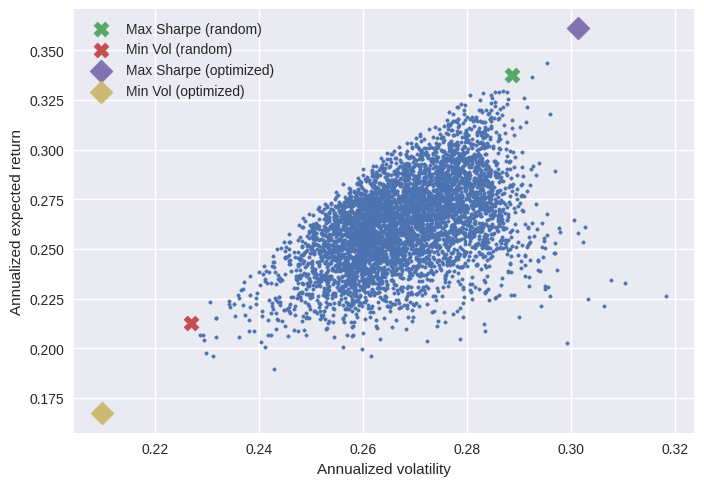

In [14]:
minvol_opt_point = portfolio_performance(w_minvol_opt, mu, cov)
maxsharpe_opt_point = portfolio_performance(w_maxsharpe_opt, mu, cov)

plt.figure()
plt.scatter(port_vols, port_returns, s=6)
plt.xlabel("Annualized volatility")
plt.ylabel("Annualized expected return")

# Random search points (your previous X markers)
plt.scatter([best_point[0]], [best_point[1]], s=120, marker="X", label="Max Sharpe (random)")
plt.scatter([minvol_point[0]], [minvol_point[1]], s=120, marker="X", label="Min Vol (random)")

# Optimized points (SLSQP)
plt.scatter([maxsharpe_opt_point[1]], [maxsharpe_opt_point[0]], s=140, marker="D", label="Max Sharpe (optimized)")
plt.scatter([minvol_opt_point[1]], [minvol_opt_point[0]], s=140, marker="D", label="Min Vol (optimized)")

plt.legend()
plt.show()


## Efficient Frontier via Target Returns (Constrained Optimization)

Random search provides an intuitive map of the feasible risk–return region but does not guarantee optimality.
To compute the efficient frontier, we solve a constrained Markowitz problem for a grid of target returns.

For each target return R*, we minimize portfolio variance subject to:
- Full investment: sum(w) = 1
- Target return: wᵀμ = R*
- Long-only: w_i ≥ 0

By varying the target return across a grid of values, we trace the entire constrained efficient frontier. This method produces the exact frontier under the specified constraints, unlike random simulation which provides only an approximation.


In [15]:
tickers = list(mu.index)
n_assets = len(tickers)

def portfolio_performance(w, mu, cov):
    w = np.array(w)
    r = float(np.dot(w, mu))
    v = float(np.sqrt(np.dot(w.T, np.dot(cov, w))))
    return r, v

def portfolio_variance(w, mu, cov):
    # variance (not volatility) for optimization stability
    w = np.array(w)
    return float(np.dot(w.T, np.dot(cov, w)))

# Base constraints
cons_sum_to_one = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# Long-only bounds
bounds = tuple((0.0, 1.0) for _ in range(n_assets))

# Initial guess
w0 = np.ones(n_assets) / n_assets

# Build target return grid (use your feasible region)
mu_min = float(mu.min())
mu_max = float(mu.max())

# Avoid extreme endpoints to reduce infeasible targets
target_returns = np.linspace(mu_min * 1.02, mu_max * 0.98, 30)

frontier_returns = []
frontier_vols = []
frontier_weights = []
frontier_success = []

for R_target in target_returns:
    cons_target_return = {'type': 'eq', 'fun': lambda w, R=R_target: np.dot(w, mu) - R}
    constraints = (cons_sum_to_one, cons_target_return)

    res = minimize(
        portfolio_variance,
        w0,
        args=(mu, cov),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"maxiter": 1000}
    )

    frontier_success.append(res.success)

    if res.success:
        w_opt = res.x
        r_opt, v_opt = portfolio_performance(w_opt, mu, cov)
        frontier_returns.append(r_opt)
        frontier_vols.append(v_opt)
        frontier_weights.append(w_opt)
    else:
        frontier_returns.append(np.nan)
        frontier_vols.append(np.nan)
        frontier_weights.append(np.nan)

frontier_returns = np.array(frontier_returns)
frontier_vols = np.array(frontier_vols)

np.sum(frontier_success), len(frontier_success)


(np.int64(30), 30)

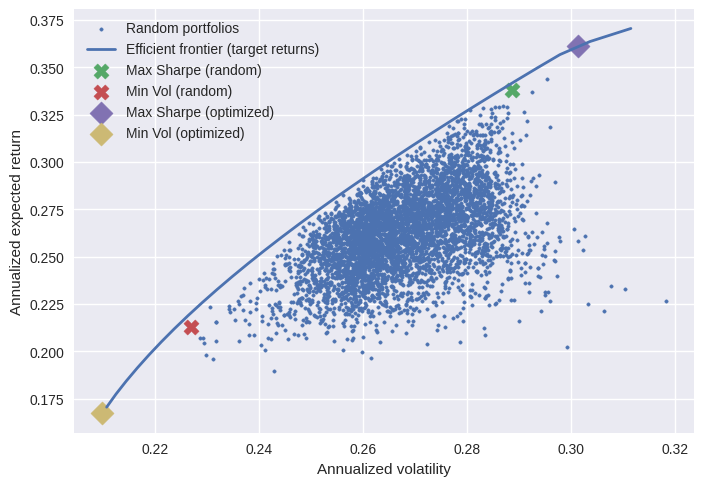

In [16]:
plt.figure()
plt.scatter(port_vols, port_returns, s=6, label="Random portfolios")

# Efficient frontier (filtered)
mask = ~np.isnan(frontier_vols) & ~np.isnan(frontier_returns)
plt.plot(frontier_vols[mask], frontier_returns[mask], linewidth=2, label="Efficient frontier (target returns)")

# Random search key points
plt.scatter([best_point[0]], [best_point[1]], s=120, marker="X", label="Max Sharpe (random)")
plt.scatter([minvol_point[0]], [minvol_point[1]], s=120, marker="X", label="Min Vol (random)")

# Optimized key points (from previous step)
minvol_opt_point = portfolio_performance(w_minvol_opt, mu, cov)      # (return, vol)
maxsharpe_opt_point = portfolio_performance(w_maxsharpe_opt, mu, cov) # (return, vol)

plt.scatter([maxsharpe_opt_point[1]], [maxsharpe_opt_point[0]], s=140, marker="D", label="Max Sharpe (optimized)")
plt.scatter([minvol_opt_point[1]], [minvol_opt_point[0]], s=140, marker="D", label="Min Vol (optimized)")

plt.xlabel("Annualized volatility")
plt.ylabel("Annualized expected return")
plt.legend()
plt.show()


The frontier is upward-sloping and concave, illustrating the trade-off between expected return and risk. As the target return increases, the portfolio becomes increasingly concentrated in higher-return assets, raising overall volatility.



## Model Limitations

This implementation relies on historical mean and covariance estimates.
The results are highly sensitive to:

- Estimation error in expected returns
- Look-back window selection
- Structural market regime changes
- Concentration risk under long-only constraints

Therefore, the efficient frontier should not be interpreted as a predictive tool,
but as a theoretical risk–return optimization framework.



## Conclusion

This notebook illustrates the full Markowitz workflow:

- Historical estimation of expected returns and covariance
- Random simulation of feasible portfolios
- Exact constrained optimization (minimum variance and maximum Sharpe)
- Construction of the efficient frontier

While the framework provides a clear theoretical structure for portfolio selection,
results depend heavily on parameter estimation.
In practice, robust methods and additional constraints are often required
to mitigate instability and concentration risk.

